In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from torchvision.utils import save_image

In [2]:
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5),(0.5))])

In [4]:
# download Dataset
train_dataset=torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset=torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 56.7MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.65MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 14.3MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 4.76MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
# Dataloader
batch_size=200
train_loader=torch.utils.data.DataLoader(train_dataset,batch_size,shuffle=True)
test_loader=torch.utils.data.DataLoader(test_dataset,batch_size,shuffle=True)

In [6]:
dataiter=iter(train_loader)
image, label=dataiter.__next__()

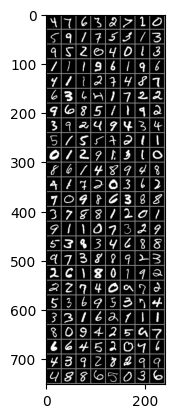

In [7]:
import numpy as np
import matplotlib.pyplot as plt
def imshow(img):
  img=img/2+0.5 #unnormalize the data # transforms the pixel values back to the range [0.0, 1.0].
  np_image=img.numpy() # Pytorch tensor to array
  plt.imshow(np.transpose(np_image,(1,2,0))) #  rearranges the dimensions from (C, H, W) to (H, W, C)
imshow(torchvision.utils.make_grid(image))

In [8]:
# Generator Model
class Generator(nn.Module):
  def __init__(self,g_input,g_output):
      super(Generator,self).__init__()
      self.fc1=nn.Linear(in_features=g_input,out_features=128)
      self.fc2=nn.Linear(in_features=128,out_features=256)
      self.fc3=nn.Linear(in_features=256,out_features=512)
      self.fc4=nn.Linear(in_features=512,out_features=1024)
      self.fc5=nn.Linear(in_features=1024,out_features=g_output)
  def forward(self,x):
    x=F.leaky_relu(self.fc1(x),0.2)
    x=F.leaky_relu(self.fc2(x),0.2)
    x=F.leaky_relu(self.fc3(x),0.2)
    x=F.leaky_relu(self.fc4(x),0.2)
    x=torch.tanh(self.fc5(x))
    return x

In [9]:
# Dicriminator Model
class Discriminator(nn.Module):
  def __init__(self,d_input):
      super(Discriminator, self).__init__()
      self.fc1=nn.Linear(in_features=d_input,out_features=1024)
      self.fc2=nn.Linear(in_features=1024,out_features=512)
      self.fc3=nn.Linear(in_features=512,out_features=256)
      self.fc4=nn.Linear(in_features=256,out_features=128)
      self.fc5=nn.Linear(in_features=128,out_features=1)
  def forward(self,x):
    x=F.leaky_relu(self.fc1(x),0.2)
    x=F.dropout(x,0.2)
    x=F.leaky_relu(self.fc2(x),0.2)
    x=F.dropout(x,0.2)
    x=F.leaky_relu(self.fc3(x),0.2)
    x=F.dropout(x,0.2)
    x=F.leaky_relu(self.fc4(x),0.2)
    x=F.dropout(x,0.2)
    x=torch.sigmoid(self.fc5(x))
    return x

In [10]:
z_dim=100 # Latent Vector
img_dim=image.shape[2]*image.shape[3]  # [200,1,28,28]
print(img_dim)

784


In [11]:
D=Discriminator(img_dim)
D

Discriminator(
  (fc1): Linear(in_features=784, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (fc5): Linear(in_features=128, out_features=1, bias=True)
)

In [12]:
G=Generator(g_input=z_dim,g_output=img_dim)
G

Generator(
  (fc1): Linear(in_features=100, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=512, bias=True)
  (fc4): Linear(in_features=512, out_features=1024, bias=True)
  (fc5): Linear(in_features=1024, out_features=784, bias=True)
)

In [13]:
#loss function and optimizer
import torch.optim as optim
criterion=nn.BCELoss()
G_optimizer=optim.Adam(params=G.parameters(),lr=0.0001)
D_optimizer=optim.Adam(params=D.parameters(),lr=0.0001)

In [14]:
# Train Discriminator
def train_discriminator(x):
  D.zero_grad()
  x_real=x.view(-1,img_dim)
  y_real=torch.ones(batch_size,1) # Real=1
  D_out=D(x_real) # Real
  D_realloss=criterion(D_out,y_real)  # Eq  4
  z=torch.randn(batch_size,z_dim)
  x_fake=G(z)
  y_fake=torch.zeros(batch_size,1) # Fake =0
  D_out1=D(x_fake)
  D_fakeloss=criterion(D_out1,y_fake)  # Eq 5
  D_loss=D_realloss+D_fakeloss  # Eq 6
  D_loss.backward()
  D_optimizer.step()
  return D_loss.data.item()

In [15]:
# Train Generator
def train_generator(x):
  G.zero_grad()
  z=torch.randn(batch_size,z_dim)
  y=torch.ones(batch_size,1)
  G_out=D(G(z))
  G_loss=criterion(G_out,y) # Eq 7
  G_loss.backward()
  G_optimizer.step()
  return G_loss.data.item()

In [17]:
num_epoch=5
D_loss=[]
G_loss=[]
for epoch in range(1,num_epoch+1):
  for i,(x,_) in enumerate(train_loader):
    G_loss.append(train_generator(x))
    D_loss.append(train_discriminator(x))
  print('[%d/%d] D_loss: %.8f, G_loss: %.8f'%(epoch,num_epoch,torch.mean(torch.FloatTensor(D_loss)), torch.mean(torch.FloatTensor(G_loss))))

[1/5] D_loss: 0.31726712, G_loss: 3.97185183
[2/5] D_loss: 0.26049808, G_loss: 4.33048344
[3/5] D_loss: 0.23321216, G_loss: 4.50058174
[4/5] D_loss: 0.22461492, G_loss: 4.65639639
[5/5] D_loss: 0.21517484, G_loss: 4.74685812


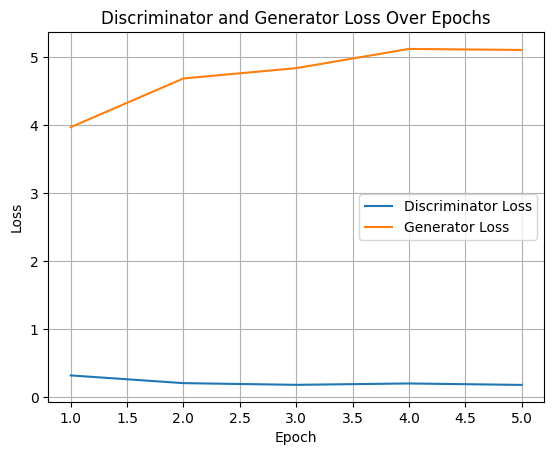

In [18]:
import matplotlib.pyplot as plt

# Calculate average losses per epoch
avg_D_loss = [torch.mean(torch.FloatTensor(D_loss[i * len(train_loader):(i + 1) * len(train_loader)]))
              for i in range(num_epoch)]
avg_G_loss = [torch.mean(torch.FloatTensor(G_loss[i * len(train_loader):(i + 1) * len(train_loader)]))
              for i in range(num_epoch)]


# Plot the average losses
plt.plot(range(1, num_epoch + 1), avg_D_loss, label='Discriminator Loss')
plt.plot(range(1, num_epoch + 1), avg_G_loss, label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Discriminator and Generator Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()



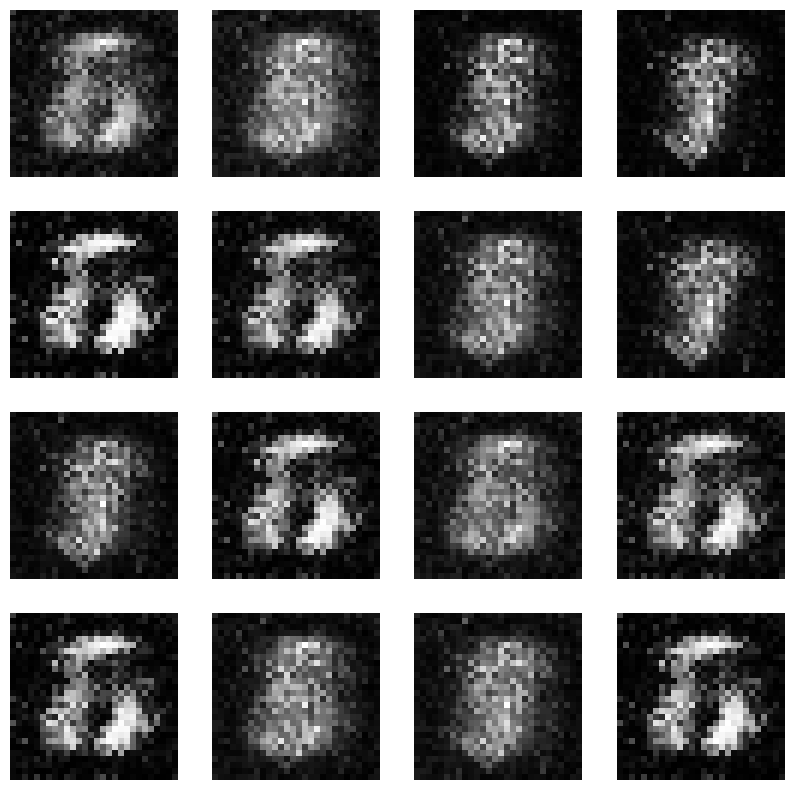

In [19]:
import matplotlib.pyplot as plt
import numpy as np

# Sample noise and generate fake images
num_images = 16  # Number of images to generate
noise = torch.randn(num_images, z_dim)
fake_images = G(noise)

# Display the generated images
fig, axes = plt.subplots(4, 4, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    img = fake_images[i].detach().numpy().reshape(28, 28)
    ax.imshow(img, cmap='gray')
    ax.axis('off')

plt.show()